In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
from tqdm import tqdm
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft, fftshift, ifftshift, ifft

In [19]:
def RK4(dydx, z, y0):    
    h = (z[1]-z[0])
    h_list = np.full(shape = len(y0), fill_value = h, dtype = float)
    y = np.zeros([len(z+1), len(y0)],dtype = complex)  
    y[0] = y0

    for iters, z_iters in enumerate(tqdm(z,desc=dydx.__name__)):
        k1 = h_list * dydx(z_iters, y[iters])
        k2 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k1)
        k3 = h_list * dydx(z_iters + 0.5 * h, y[iters] + 0.5 * k2)
        k4 = h_list * dydx(z_iters + h, y[iters] + k3)
        
        if iters == len(z)-1:
            break
        y[iters+1] = y[iters] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return y

def OPA(z, S, p):
    A1, A2, A3 = S
    K1, K2, K3 = p
    return (1j*K1*A3*np.conj(A2)*np.exp(1j*delta_k*z),1j*K2*A3*np.conj(A1)*np.exp(1j*delta_k*z), 
            1j*K3*A1*A2*np.exp(-1j*delta_k*z))

def N(z,S,p):
    Es, Ei, Ep = S
    Ks, Ki, Kp = p
    return np.array([1j*Ks*Ep*np.conj(Ei), 1j*Ki*Ep*np.conj(Es), 1j*Kp*Es*Ei])

https://www.castech-us.com/caslnb.htm:

![](KILL.jpg)

In [20]:
c = 3*10**8
def ref(omega):
    return np.sqrt(4.9048+0.11768/((2*np.pi*c/omega*10**6)**2-0.04750)-0.027169*(2*np.pi*c/omega*10**6)**2)

print(ref(4*10**15))
print(2*np.pi*c/(10**15)*10**6)

2.360698050679705
1.8849555921538759


$$\frac{dA_s}{dz} = \frac{2id_{eff}\omega_s^2}{k_sc^2}A_pA_i^*e^{-i\Delta kz}$$
$$\frac{dA_i}{dz} = \frac{2id_{eff}\omega_i^2}{k_ic^2}A_pA_s^*e^{-i\Delta kz}$$
$$\frac{dA_p}{dz} = \frac{2id_{eff}\omega_p^2}{k_pc^2}A_sA_ie^{i\Delta kz}$$

$$\Delta k = k_p - (k_i+k_s)$$

\begin{align}\label{eq:2}
    \begin{split}
    \frac{dE_s}{dz} & = \frac{2id_{eff}\omega_s^2}{k_sc^2}E_pE_i^* + ik_s E_s\\
    \frac{dE_i}{dz} & = \frac{2id_{eff}\omega_i^2}{k_ic^2}E_pE_s^* + ik_i E_i\\
    \frac{dE_p}{dz} & = \frac{2id_{eff}\omega_p^2}{k_pc^2}E_sE_i + ik_p E_p
    \end{split}
\end{align}

In [25]:
z_max = 5*10**-9 #5 mm default
itr = 1*10**5
z = np.linspace(0,z_max,itr)
Ks = 1*1.524*10**3; Ki = 1.524*10**3; Kp =2*1.524*10**3
ks = 6*10**6; ki = 6*10**6; kp = 2*6*10**6
p1 = np.array([Ks, Ki, Kp]); p2 = np.array([ks, ki, kp])
As = 0.2+0.0j; Ai = 0.0+0.0j; Ap = As*5;
y0 = np.array([As, Ai, Ap])
print(kp-ks-ki)

0


In [26]:
def splitOPA(NLfunc, p1, p2, z, y0):
    h = (z[1]-z[0]) #delta z
    y = np.zeros([len(z+1), len(y0)],dtype = complex)  
    y[0] = y0
    N = len(z)
    expy = np.exp(1j*p2*h)
    for iters, z_iters in enumerate(tqdm(z)):
        k1 = h * NLfunc(z_iters, y[iters], p1)
        k2 = h * NLfunc(z_iters + 0.5 * h, y[iters] + 0.5 * k1, p1)
        k3 = h * NLfunc(z_iters + 0.5 * h, y[iters] + 0.5 * k2, p1)
        k4 = h * NLfunc(z_iters + h, y[iters] + k3, p1)
                
        if iters == len(z)-1:
            break
        y[iters+1] = y[iters] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) #RK4 NL term
        y[iters+1] = ifft(ifftshift(fft(fftshift(y[iters+1]))*expy))
    return y

    

In [27]:
y_list = splitOPA(N, p1, p2, z, y0)
U1_list = (np.abs(y_list[:,0])**2)
U2_list = (np.abs(y_list[:,1])**2)
U3_list = (np.abs(y_list[:,2])**2)


100%|█████████▉| 99999/100000 [00:13<00:00, 7327.83it/s]


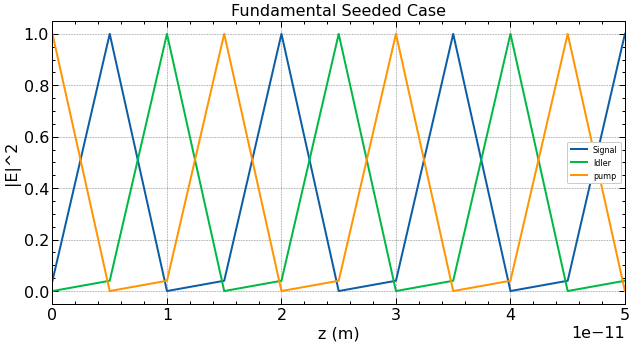

In [28]:
fig, ax = plt.subplots(figsize=(9, 5), tight_layout=True)
ax.plot(z,U1_list)
ax.plot(z,U2_list)
ax.plot(z,U3_list)
ax.set_ylabel("|E|^2")
plt.xlim([0,5*10**-11])
plt.legend(["Signal", "Idler", "pump"],prop={'size': 8})
plt.title("Fundamental Seeded Case")
#plt.axis([0, 0.03, 0, 25])
#plt.savefig('Real param qpm image 1GW 2', bbox_inches='tight')
plt.xlabel('z (m)')
plt.show()

In [ ]:
def NL(z, S, p):
    U1, U2, U3, U4 = S
    G211, G321, G431, G422 = p
    return (1j*(2*gamma211*U2*np.conj(U1)+gamma321*U3*np.conj(U2)+gamma431*U4*np.conj(U3)),
            1j*(gamma211*U1**2+gamma321*U3*np.conj(U1)+2*gamma422*U4*np.conj(U2)),
            1j*(gamma321*U2*U1+gamma431*U4*np.conj(U1)),
            1j*(gamma422*U2**2+gamma431*U3*U1))

In [ ]:
def splitTHG(NLfunc, p1, p2, z, y0):
    h = (z[1]-z[0])
    h_list = np.full(shape = len(y0), fill_value = h, dtype = float)
    y = np.zeros([len(z+1), len(y0)],dtype = complex)  
    y[0] = y0

    for iters, z_iters in enumerate(tqdm(z)):
        k1 = h_list * NLfunc(z_iters, y[iters], p1)
        k2 = h_list * NLfunc(z_iters + 0.5 * h, y[iters] + 0.5 * k1, p1)
        k3 = h_list * NLfunc(z_iters + 0.5 * h, y[iters] + 0.5 * k2, p1)
        k4 = h_list * NLfunc(z_iters + h, y[iters] + k3, p1)
                
        if iters == len(z)-1:
            break
        y[iters+1] = y[iters] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
        y[iters+1] = np.multiply(fft(y[iters+1]),
                     [np.exp(1j*p2[0]*h), np.exp(1j*p2[1]*h), np.exp(1j*p2[2]*h), np.exp(1j*p2[3]*h)])
        y[iters+1] = ifft(y[iters+1])
    return y

gamma211 = 1.524*10**4/np.sqrt(10); gamma321 = 0; gamma431 = 4.1744*10**4/np.sqrt(10); gamma422 = 7.2132*10**4/np.sqrt(10)
k1 = 0; k2 = 2*k1; k3 = 3*k1; k4 = 4*k1
pO = [gamma211, gamma321, gamma431, gamma422]; pI = [k1,k2,k3,k4];
A1 = 1+0.0j; A2 = 0.0+0.0j; A3 = 0.0+0.0j; A4 = 0.0+0.0j;
y1 = [A1, A2, A3, A4]
print(k2-2*k1)  
print(k3-k1-k2)  
print(k4-2*k2)  
print(k4-k1-k3)  


In [ ]:
y_list = splitTHG(NL, pO, pI, z, y1)
U1_list = (np.abs(y_list[:,0])**2)
U2_list = (np.abs(y_list[:,1])**2)
U3_list = (np.abs(y_list[:,2])**2)
U4_list = (np.abs(y_list[:,3])**2)

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(z,U1_list)
plt.plot(z,U2_list)
plt.plot(z,U3_list)
plt.plot(z,U4_list)

plt.xlabel("$\mathbf{z}$ $\mathbf{(mm)}$")
plt.ylabel("$\mathbf{n(z)}$")

plt.legend(["$n_{Fundamental}$", "$n_{Second}$", "$n_{Third}$", "$n_{Fourth}$"],prop={'size': 12})
plt.title("$\mathbf{Novel}$ $\mathbf{Third}$ $\mathbf{Harmonic}$ $\mathbf{Generation}$ $\mathbf{(KTP)}$ ", loc='left', fontsize=15)
plt.title("No QPM", loc='right', fontsize=12, color='grey', style='italic')
#plt.savefig('QPM KTP 2', bbox_inches='tight')
plt.show()